# Conformal Regression (Built on top of DER)
Romano+'s approach to quantile regression, these are heuristic.
Turn this into a score function, which we then calibrate with conformal prediction

In [1]:
import torch
import functools
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

In [2]:
import sys
sys.path.append('..')
from src.scripts import train, models, analysis, evaluate_uncert

In [3]:
def get_best_device(fallback="cpu"):
    return torch.device("cuda:0" if torch.cuda.is_available() else fallback)

In [4]:
DEVICE = get_best_device()

In [5]:
DER_TYPE = 'DER'  # 'sDER'
norm = 'False' # if you normalize, rn the normalized version doesn't work

In [6]:
BATCH_SIZE = 100
N_SAMPLES = 50
N_EPOCHS = 500

if DER_TYPE == 'DER':
    LR = 5e-4    # learning rate
    COEFF = .01  # lambda
else:
    LR = .005    # learning rate
    COEFF = 2.   # lambda

In [7]:
if DER_TYPE == 'DER':
    DERLayer = models.DERLayer
    loss_der = models.loss_der
else:
    DERLayer = models.SDERLayer
    loss_der = models.loss_sder

## Generate data
This is the same as in the DeepEnsemble

In [46]:
# same simulator as in likelihood-based inference,
# but here we have 
def simulator(thetas):
    m, b = thetas
    x_data = np.linspace(0, 100, 101)
    rs = np.random.RandomState()#2147483648)# 
    sigma = 10
    ε = rs.normal(loc=0, scale=sigma, size = len(x_data)) 
    return m * x_data + b + ε, ε

def simulator_no_noise(thetas):
    m, b = thetas
    x_data = np.linspace(0, 100, 101)
    rs = np.random.RandomState()#2147483648)# 
    return m * x_data + b

In [9]:
x_data = np.linspace(0, 100, 101)

length_df = 1000
#ms = np.zeros((length_df, 101))
ms_list = []#np.zeros((length_df, 1))
bs_list = []#np.zeros((length_df, 1))
ys_list = []
ys_list_true_error = []
#true_sigmas = []

for r in range(length_df):
    rs = np.random.RandomState()#2147483648)# 
    m = rs.uniform(low=0, high=10)
    b = rs.uniform(low=-10, high=10)    
    ms_list.append(m)
    bs_list.append(b)
    '''
    xs[r,:] = thetas_1d[0]#np.linspace(0, 100, 101)
    ms[r,:] = thetas_1d[1]#np.repeat(thetas_1d[0], 101)
    bs[r,:] = thetas_1d[2]#np.repeat(thetas_1d[1], 101)
    sigmas[r,:] = thetas_1d[3]#np.repeat(thetas_1d[2], 101)
    '''
    ys_list.append(simulator([m,b]))
ms_array = np.repeat(ms_list, len(x_data))
bs_array = np.repeat(bs_list, len(x_data))
xs_array = np.tile(x_data, length_df)
ys_array = np.reshape(ys_list, (length_df * len(x_data)))

<Figure size 640x480 with 0 Axes>

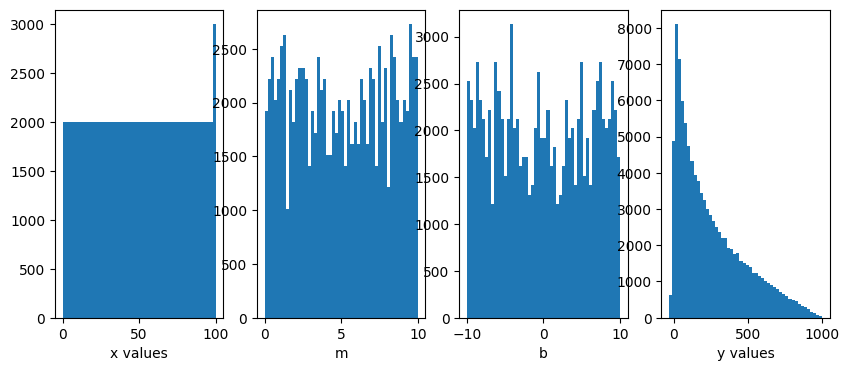

In [10]:
plt.clf()
fig = plt.figure(figsize = (10,4))
ax0 = fig.add_subplot(141)
ax0.hist(xs_array, bins=50)
ax0.set_xlabel('x values')
ax1 = fig.add_subplot(142)
ax1.hist(ms_array, bins=50)
ax1.set_xlabel('m')
ax2 = fig.add_subplot(143)
ax2.hist(bs_array, bins=50)
ax2.set_xlabel('b')
ax3 = fig.add_subplot(144)
ax3.hist(ys_array, bins=50)
ax3.set_xlabel('y values')
plt.show()

In [11]:
# combine all of the inputs into one array
# this will be fed into the neural network
inputs = np.array([xs_array, ms_array, bs_array]).T
print(np.shape(inputs))

(101000, 3)


In [12]:
if norm == 'True':
    print('normalized version', norm)
    # normalize everything before it goes into a network
    inputmin = np.min(inputs, axis = 0)
    inputmax = np.max(inputs, axis = 0)#, axis = 0)
    outputmin = np.min(ys_array)
    outputmax = np.max(ys_array)
    model_inputs = (inputs - inputmin) / (inputmax - inputmin)
    model_outputs = (ys_array - outputmin) / (outputmax - outputmin)
else:
    print('not normalizing')
    model_inputs = inputs
    model_outputs = ys_array

not normalizing


<Figure size 640x480 with 0 Axes>

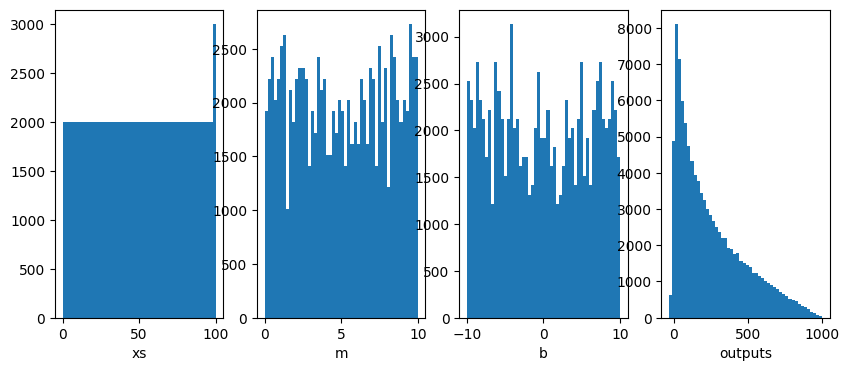

In [13]:
# now plot the histograms of the noramlized values
# to verify it worked
plt.clf()
fig = plt.figure(figsize = (10,4))
ax0 = fig.add_subplot(141)
ax0.hist(model_inputs[:,0], bins=50)
ax0.set_xlabel('xs')
ax1 = fig.add_subplot(142)
ax1.hist(model_inputs[:,1], bins=50)
ax1.set_xlabel('m')
ax2 = fig.add_subplot(143)
ax2.hist(model_inputs[:,2], bins=50)
ax2.set_xlabel('b')
ax3 = fig.add_subplot(144)
ax3.hist(model_outputs[:], bins=50)
ax3.set_xlabel('outputs')
plt.show()

(90900, 3) (90900,)
(3,)


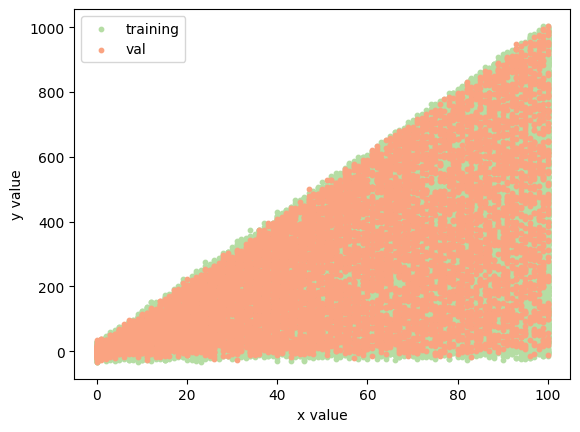

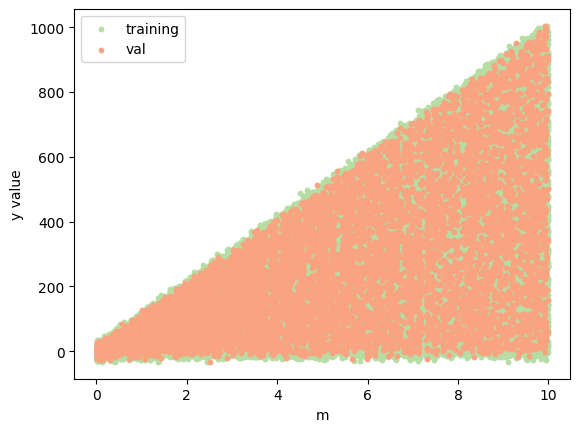

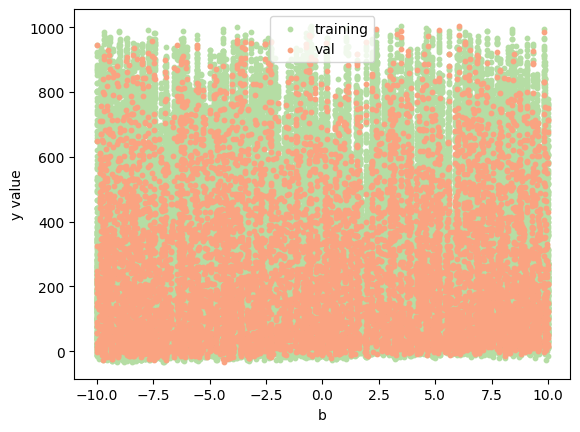

In [14]:
# prepare the training, validation, and test set split:
val_proportion = 0.1
x_train, x_val, y_train, y_val = train_test_split(model_inputs, model_outputs, test_size=val_proportion, random_state=42)

print(np.shape(x_train), np.shape(y_train))
print(np.shape(x_train[:][0]))


plt.clf()
plt.scatter(x_train[:,0], y_train, label = 'training', color = '#B5DDA4', s = 10)
plt.scatter(x_val[:,0], y_val, label = 'val', color = '#FAA381', s = 10)
plt.legend()
plt.xlabel('x value')
plt.ylabel('y value')
plt.show()

plt.clf()
plt.scatter(x_train[:,1], y_train, label = 'training', color = '#B5DDA4', s = 10)
plt.scatter(x_val[:,1], y_val, label = 'val', color = '#FAA381', s = 10)
plt.legend()
plt.xlabel('m')
plt.ylabel('y value')
plt.show()

plt.clf()
plt.scatter(x_train[:,2], y_train, label = 'training', color = '#B5DDA4', s = 10)
plt.scatter(x_val[:,2], y_val, label = 'val', color = '#FAA381', s = 10)
plt.legend()
plt.xlabel('b')
plt.ylabel('y value')
plt.show()

In [15]:
# okay now train the thing
BATCH_SIZE = 128

# add a dimension so that xs have a one channel input
#x_train = x_train.reshape(x_train.shape[0], 1) # 1 was the middle dimension
#x_val = x_val.reshape(x_val.shape[0], 1)

'''
print('y', np.shape(y_train))
print('x', np.shape(x_train))
STOP
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1]) # 1 was the middle dimension
x_val = x_val.reshape(x_val.shape[0], x_val.shape[1])
#x_test = x_test.reshape(x_test.shape[0], 1, x_test.shape[1], x_test.shape[1])
'''

trainData = TensorDataset(torch.Tensor(x_train), torch.Tensor(y_train))
trainDataLoader = DataLoader(trainData, batch_size=BATCH_SIZE, shuffle=True)

valData = TensorDataset(torch.Tensor(x_val), torch.Tensor(y_val))
valDataLoader = DataLoader(valData, batch_size=BATCH_SIZE)

# calculate steps per epoch for training and validation set
trainSteps = len(trainDataLoader.dataset) // BATCH_SIZE
valSteps = len(valDataLoader.dataset) // BATCH_SIZE

print('shape of training set', np.shape(x_train))

shape of training set (90900, 3)


[INFO] training the network...
saving checkpoints?
False
starting here 0
epoch 0 0.0


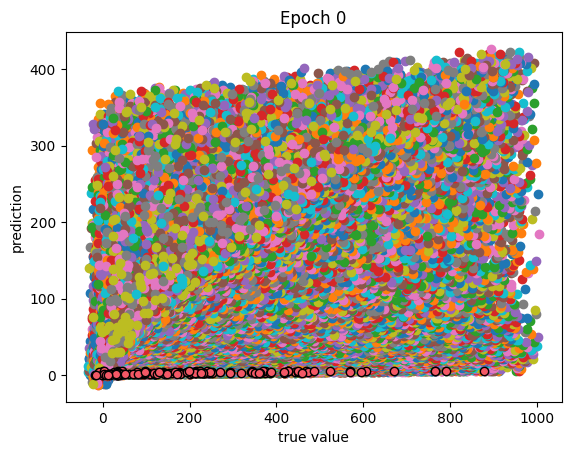

new best loss 7.331765174865723 in epoch 0
epoch 1 0.1
new best loss 5.491945743560791 in epoch 1
epoch 2 0.2
new best loss 4.992016792297363 in epoch 2
epoch 3 0.3
new best loss 4.734766483306885 in epoch 3
epoch 4 0.4
new best loss 4.519942283630371 in epoch 4
epoch 5 0.5


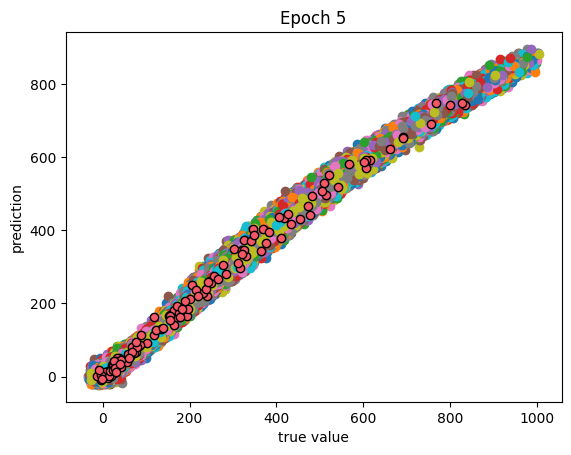

new best loss 4.307188987731934 in epoch 5
epoch 6 0.6
new best loss 4.198755264282227 in epoch 6
epoch 7 0.7
new best loss 4.105175018310547 in epoch 7
epoch 8 0.8
new best loss 4.065346717834473 in epoch 8
epoch 9 0.9
new best loss 4.009360313415527 in epoch 9
start at 1704824656.3920891 end at 1704824666.060645
9.668555974960327


<Figure size 640x480 with 0 Axes>

In [16]:
# my own training model
DER_type = 'DER'
INIT_LR = LR
model = train.train_DER(trainDataLoader,
             x_val,
             y_val,
             INIT_LR,
             DEVICE,
             COEFF,
             DER_type,
             model_name='DER',
             EPOCHS=10,
             save_checkpoints=False,
             plot=True)
 

### Compute the uncertainty
The original aleatoric and epistemic uncertainty (from OG paper):
$u_{al} = \sqrt{\frac{\beta_i}{(\alpha_i-1)}}$; $u_{ep} = \sqrt{\frac{\beta_i}{v_i(\alpha_i-1)}}$

The revised aleatoric and epistemic uncertainty:
$u_{al} = \sqrt{\frac{\beta_i (1+v_i)}{\alpha_i v_i}}$; $u_{ep} = \frac{1}{\sqrt{v_i}}$

The order of the parameters for a normal-inverse-gamma distribution is:
$$m = (\gamma, \nu, \alpha, \beta)$$

### Plot the aleatoric errors by data point

In [47]:
m_true = np.repeat(1, len(x_data))
b_true = np.repeat(5, len(x_data))


thetas_1d_true = np.array([x_data, m_true, b_true]).T
y_true, y_true_error = simulator([m_true[0], b_true[0]])
y_true_no_noise = simulator_no_noise([m_true[0], b_true[0]])
# now use the NN to make a prediction
model.eval()
# first, normalize the x value using the xmin and xmax before
if norm == 'True':
    norm_thetas = (thetas_1d_true - inputmin) / (inputmax - inputmin)
    
    y_norm_pred = model(torch.Tensor(norm_thetas)).detach().numpy()
    # now un-normalize this so you can plot it
    
    
    y_pred = (y_norm_pred[:,0]) * (outputmax - outputmin) + outputmin
    # I think I'm doing the un-normalization wrong for the other terms in the output:
    aleatoric_OG = np.sqrt((y_norm_pred[:,3] * (outputmax - outputmin) + outputmin) / ((y_norm_pred[:,2]* (outputmax - outputmin) + outputmin) - 1))
    aleatoric_mod = np.sqrt(((y_norm_pred[:,3] * (outputmax - outputmin) + outputmin) * (1 + (y_norm_pred[:,1] * (outputmax - outputmin) + outputmin))) / ((y_norm_pred[:,2]* (outputmax - outputmin) + outputmin) * (y_norm_pred[:,1]* (outputmax - outputmin) + outputmin)))
    epistemic_OG = np.sqrt(y_norm_pred[:,3] / (y_norm_pred[:,1]*(y_norm_pred[:,2] - 1)))
    epistemic_mod = 1 / np.sqrt(y_norm_pred[:,1])
else:
    y_pred_all_terms = model(torch.Tensor(thetas_1d_true)).detach().numpy()
    # now un-normalize this so you can plot it
    
    
    y_pred = y_pred_all_terms[:,0]
    aleatoric_OG = np.sqrt(y_pred_all_terms[:,3] / (y_pred_all_terms[:,2] - 1))
    aleatoric_mod = np.sqrt((y_pred_all_terms[:,3]  * (1 + y_pred_all_terms[:,1] )) / (y_pred_all_terms[:,2] * y_pred_all_terms[:,1]))
    epistemic_OG = np.sqrt(y_pred_all_terms[:,3] / (y_pred_all_terms[:,1]*(y_pred_all_terms[:,2] - 1)))
    epistemic_mod = 1 / np.sqrt(y_pred_all_terms[:,1])

/var/folders/5m/wnsjjcln435g2yq5mmxf45k00000gz/T/ipykernel_74056/1128139444.py:30: RuntimeWarning: divide by zero encountered in divide
  aleatoric_OG = np.sqrt(y_pred_all_terms[:,3] / (y_pred_all_terms[:,2] - 1))
/var/folders/5m/wnsjjcln435g2yq5mmxf45k00000gz/T/ipykernel_74056/1128139444.py:32: RuntimeWarning: divide by zero encountered in divide
  epistemic_OG = np.sqrt(y_pred_all_terms[:,3] / (y_pred_all_terms[:,1]*(y_pred_all_terms[:,2] - 1)))


<Figure size 640x480 with 0 Axes>

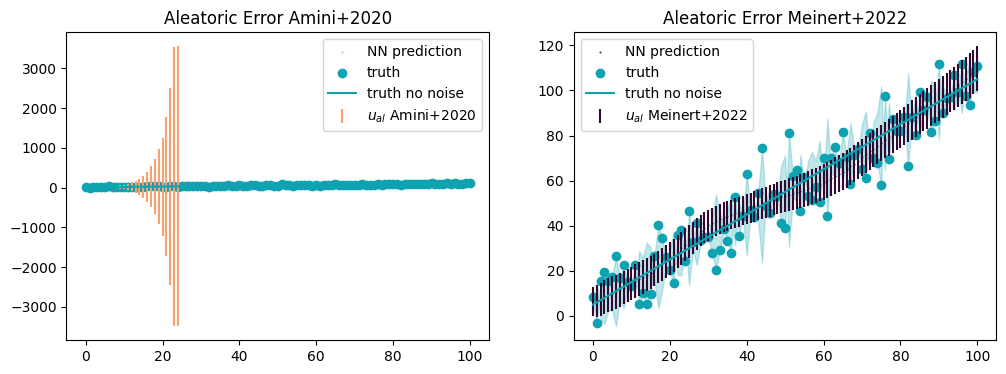

In [48]:
# plot
plt.clf()
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(121)
ax1.scatter(x_data, y_pred, label = 'NN prediction', color = '#F7A072', s = 0.2)
ax1.errorbar(x_data, y_pred, yerr = aleatoric_OG,
             label = r'$u_{al}$ Amini+2020', color = '#F7A072',
             ls = 'None')
ax1.scatter(x_data, y_true, label = 'truth', color = '#0FA3B1')
ax1.plot(x_data, y_true_no_noise, label = 'truth no noise', color = '#0FA3B1')
ax1.fill_between(x_data, y_true_no_noise - 10,
                 y_true_no_noise + 10, color = '#0FA3B1', alpha = 0.25)

plt.legend()
ax1.set_title('Aleatoric Error Amini+2020')

ax2 = fig.add_subplot(122)
# now plot the prediction from the NN
ax2.scatter(x_data, y_pred, label = 'NN prediction', color = '#310A31', s = 0.2)
ax2.errorbar(x_data, y_pred, yerr = aleatoric_mod,
             label = r'$u_{al}$ Meinert+2022', color = '#310A31',
             ls = 'None')
ax2.scatter(x_data, y_true, label = 'truth', color = '#0FA3B1')
ax2.plot(x_data, y_true_no_noise, label = 'truth no noise', color = '#0FA3B1')
ax2.fill_between(x_data, y_true_no_noise - y_true_error,
                 y_true_no_noise + y_true_error, color = '#0FA3B1', alpha = 0.25)

plt.legend()
ax2.set_title('Aleatoric Error Meinert+2022')
plt.show()

### Now epistemic

In [19]:
print, epistemic_OG, epistemic_mod 

(<function print>,
 array([   43.61062 ,    51.768944,    60.11895 ,    67.70073 ,
           78.93916 ,    93.20162 ,   112.87383 ,   143.14023 ,
          190.19609 ,   260.66608 ,   357.25858 ,   489.68427 ,
          664.86176 ,   902.3302  ,  1219.2665  ,  1636.6599  ,
         2220.3904  ,  3020.3926  ,  4165.56    ,  5598.997   ,
         7450.054   , 10545.161   , 14816.092   , 20816.625   ,
        20680.826   ,          inf,          inf,          inf,
                 inf,          inf,          inf,          inf,
                 inf,          inf,          inf,          inf,
                 inf,          inf,          inf,          inf,
                 inf,          inf,          inf,          inf,
                 inf,          inf,          inf,          inf,
                 inf,          inf,          inf,          inf,
                 inf,          inf,          inf,          inf,
                 inf,          inf,          inf,          inf,
                 inf,

<Figure size 640x480 with 0 Axes>

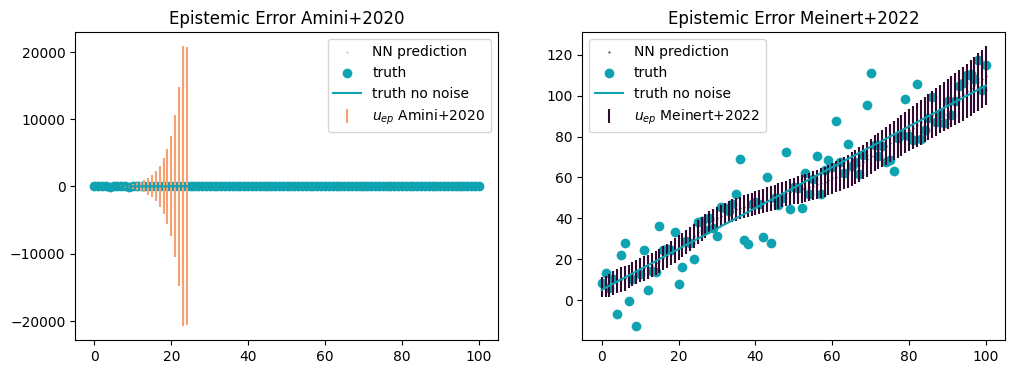

In [20]:
# plot
plt.clf()
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(121)
ax1.scatter(x_data, y_pred, label = 'NN prediction', color = '#F7A072', s = 0.2)
ax1.errorbar(x_data, y_pred, yerr = epistemic_OG,
             label = r'$u_{ep}$ Amini+2020', color = '#F7A072',
             ls = 'None')
ax1.scatter(x_data, y_true, label = 'truth', color = '#0FA3B1')
ax1.plot(x_data, y_true_no_noise, label = 'truth no noise', color = '#0FA3B1')
plt.legend()
ax1.set_title('Epistemic Error Amini+2020')

ax2 = fig.add_subplot(122)
# now plot the prediction from the NN
ax2.scatter(x_data, y_pred, label = 'NN prediction', color = '#310A31', s = 0.2)
ax2.errorbar(x_data, y_pred, yerr = epistemic_mod,
             label = r'$u_{ep}$ Meinert+2022', color = '#310A31',
             ls = 'None')
ax2.scatter(x_data, y_true, label = 'truth', color = '#0FA3B1')
ax2.plot(x_data, y_true_no_noise, label = 'truth no noise', color = '#0FA3B1')
plt.legend()
ax2.set_title('Epistemic Error Meinert+2022')
plt.show()


### Now that intervals are obtained we can apply conformalization
First trying this with the Meinert+2022 aleatoric uncertainty.

Guaranteeing 68.0% coverage


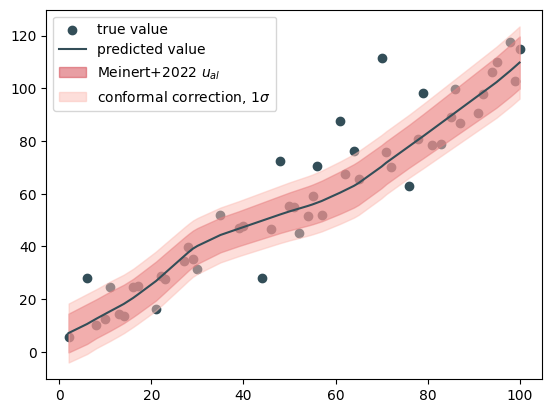

In [21]:
conf = evaluate_uncert.ConformalPredictor(model)
prediction_sets = conf.conformal_intervals(thetas_1d_true,
                            y_true,
                            y_pred,
                            aleatoric_mod,
                            0.32)

### Compare predicted uncertainty with true uncertainty
Using Spearman's rank coefficient.

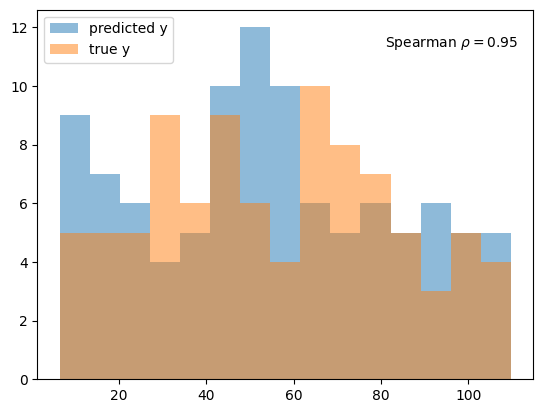

In [41]:
spear = evaluate_uncert.SpearmanRankCalculator()
spearr = spear.calculate_spearman_rank(y_pred, y_true)
values, bins = np.histogram(y_pred, bins = 15)
plt.hist(y_pred, bins=bins, alpha = 0.5, label = 'predicted y')
plt.hist(y_true, bins = bins, alpha = 0.5, label = 'true y')
plt.annotate(r'Spearman $\rho = $'+str(round(spearr, 2)),
             xy = (0.7, 0.9),
             xycoords = 'axes fraction')
plt.legend(loc = 'upper left')
plt.show()


[6.5547533 7.040589  7.3665752 7.4688997 7.582088  7.704858  7.567815
 7.4242926 7.3723803 7.3997245 7.42597   7.4516487 7.4022336 7.3493524
 7.2840962 7.183677  7.211875  7.2509704 7.2918754 7.333023  7.3744097
 7.3807435 7.3346443 7.2888055 7.2432194 7.197903  7.1486897 7.0410066
 6.9350863 6.846892  6.783096  6.7333155 6.685862  6.6384277 6.6096487
 6.587798  6.580716  6.5890665 6.5970855 6.6066885 6.653831  6.701247
 6.7489314 6.7968946 6.8451233 6.893619  6.9423857 6.9914107 7.0407124
 7.121961  7.1875625 7.25365   7.320232  7.3873124 7.4548707 7.530956
 7.621032  7.712232  7.804602  7.881152  7.95004   8.019295  8.088938
 8.158966  8.229349  8.27433   8.318826  8.313323  8.275302  8.237999
 8.177994  8.115285  8.114012  8.1180315 8.121019  8.12302   8.133719
 8.205426  8.285279  8.365464  8.443739  8.5220995 8.60086   8.680049
 8.759649  8.839669  8.920097  9.000942  9.082162  9.163809  9.2458515
 9.328301  9.411151  9.494399  9.578041  9.660899  9.715186  9.769421
 9.8236265 9.8

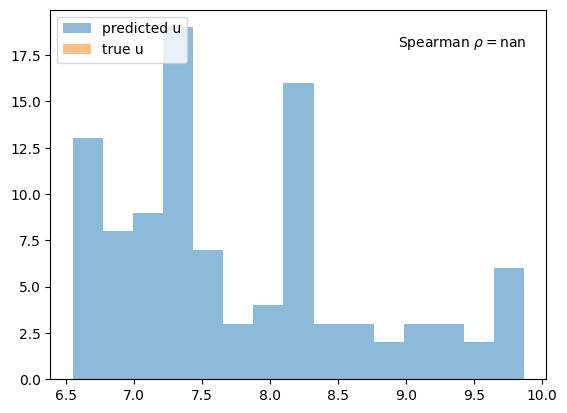

In [44]:
spearr = spear.calculate_spearman_rank(aleatoric_mod, np.repeat(10,len(aleatoric_mod)))
values, bins = np.histogram(aleatoric_mod, bins = 15)
plt.hist(aleatoric_mod, bins=bins, alpha = 0.5, label = 'predicted u')
plt.hist( np.repeat(10, len(aleatoric_mod)), bins = bins, alpha = 0.5, label = 'true u')
plt.annotate(r'Spearman $\rho = $'+str(round(spearr, 2)),
             xy = (0.7, 0.9),
             xycoords = 'axes fraction')
plt.legend(loc = 'upper left')
plt.show()

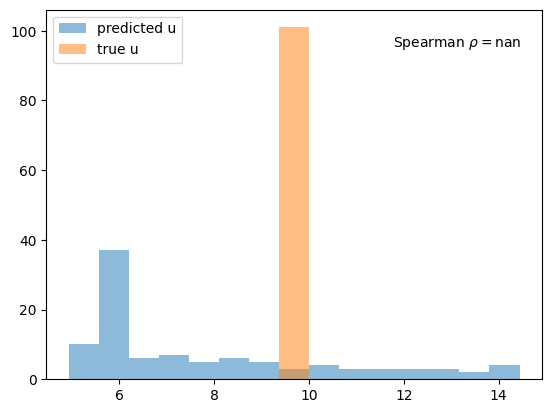

In [45]:
spearr = spear.calculate_spearman_rank(epistemic_mod, np.repeat(10,len(aleatoric_mod)))
values, bins = np.histogram(epistemic_mod, bins = 15)
plt.hist(epistemic_mod, bins=bins, alpha = 0.5, label = 'predicted u')
plt.hist(np.repeat(10, len(aleatoric_mod)), bins = bins, alpha = 0.5, label = 'true u')
plt.annotate(r'Spearman $\rho = $'+str(round(spearr, 2)),
             xy = (0.7, 0.9),
             xycoords = 'axes fraction')
plt.legend(loc = 'upper left')
plt.show()